# Hugoniot for Helium
Purpose of this notebook is to do Hugoniot calculations for Helium

["Hugoniot Data for Helium in the Ionization Regime"- Eggert 2008](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.100.124503)

["First Principles Calculations of Shock Compressed Fluid Helium"- Millitzer 2006](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.97.175501)


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pandas import read_csv

from hnc.hnc.PIE import Plasma_of_Ions_and_Electrons as PLASMA

from hnc.hnc.constants import *
from hnc.hnc.misc import n_from_rs, rs_from_n

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
                
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}

</style>
""")


ModuleNotFoundError: No module named 'mendeleev'


#### Define Various Plasma Models

In [2]:
P_hnc_to_AU   = lambda P_hnc, ri: (P_hnc/ri**3) 
P_hnc_to_Mbar = lambda P_hnc, ri: P_hnc_to_AU(P_hnc, ri)*AU_to_bar/1e6
P_hnc_to_GPa = lambda P_hnc, ri: P_hnc_to_AU(P_hnc, ri)*AU_to_Pa/1e9

def plasma_output(plasma):
    plasma.run_hnc()
    try: 
        plasma.hnc.βu_r_matrix[1,1] -= plasma.βP_ee
    except:
        plasma.hnc.βu_r_matrix[1,1] -= plasma.qsp.βv_Pauli(plasma.hnc.r_array, plasma.qsp.Λee)
    P_hnc, E_density_hnc  = plasma.hnc.total_pressure(),  plasma.hnc.total_energy_density() 
    E_AU = E_density_hnc/plasma.hnc.rho[0]
    P_AU = P_hnc_to_AU(P_hnc, plasma.qsp.ri)
    try: 
        plasma.hnc.βu_r_matrix[1,1] += plasma.βP_ee
    except:
        plasma.hnc.βu_r_matrix[1,1] += plasma.qsp.βv_Pauli(plasma.hnc.r_array, plasma.qsp.Λee)
    
    return P_AU, E_AU 

name1 = 'OZ - g'
plasma1 = lambda T_eV, ni_cc: PLASMA(Z, A, ni_cc, T_eV, T_eV, Zbar=Z,
                 βu_options = {'add_bridge':False,'bridge':'ocp', 'pseudopotential':False}, 
                 qsp_options= {'r_c':0,'which_Tij':'geometric'},
                 hnc_options= {'kappa_multiscale':10, 'R_max':10,'N_bins':500, 
                               'h_max':2e2,'oz_method':'standard'},
                 hnc_solve_options={'alpha_Picard':0.5, 'num_iterations':1e4})
name2 = 'OZ - th'
plasma2 = lambda T_eV, ni_cc: PLASMA(Z, A, ni_cc, T_eV, T_eV, Zbar=Z,
                 βu_options = {'add_bridge':False,'bridge':'ocp', 'pseudopotential':False}, 
                 qsp_options= {'r_c':0,'which_Tij':'thermal'},
                 hnc_options= {'kappa_multiscale':10, 'R_max':10,'N_bins':500, 
                               'h_max':2e2,'oz_method':'standard'},
                 hnc_solve_options={'alpha_Picard':0.5, 'num_iterations':1e4})
name3 = 'OZ - th  Pauli'
plasma3 = lambda T_eV, ni_cc: PLASMA(Z, A, ni_cc, T_eV, T_eV, Zbar=Z, find_βuee=True,
                 βu_options = {'add_bridge':False,'bridge':'ocp', 'pseudopotential':False}, 
                 qsp_options= {'r_c':0,'which_Tij':'thermal'},
                 hnc_options= {'kappa_multiscale':10, 'R_max':10,'N_bins':500, 
                               'h_max':2e2,'oz_method':'standard'},
                 hnc_solve_options={'alpha_Picard':0.5, 'num_iterations':1e4})
name4 = 'SVT - th'
plasma4 =  lambda T_eV, ni_cc: PLASMA(Z, A, ni_cc, T_eV, T_eV, Zbar=Z,
                 βu_options = {'add_bridge':False,'bridge':'ocp', 'pseudopotential':False}, 
                 qsp_options= {'r_c':0},
                 hnc_options= {'kappa_multiscale':10, 'R_max':10,'N_bins':500, 
                               'h_max':2e2,'oz_method':'svt'},
                 hnc_solve_options={'alpha_Picard':0.5,'num_iterations':1e4})

# Hugoniot Description and Assumptions

From "Monte Carlo results for the hydrogen Hugoniot", we assume the hock Hugoniot curve is given by (note there is a sign typo in the paper)
$$H = E-E_0 + \frac{1}{2}(p+p_0)(V-V_0)= 0
$$
With initial conditions given by
\begin{align}
p_0 = 0.12 GPa,\  \rho_0 = 0.123 \textrm{ g/cm$^3$}, \ E_0 = ? \textrm{ eV/atom}
\end{align}

Say we compute E(n, T), P(n, T) then we have 2 free parameters, potentially plotted in P, n space. Instead, we constrain with 1 equation, that given above.

In this case we need to first compute the initial condition temperature to get the $E_0$ in the Hugoniot

### Set Element and Known Parts of Initial Conditions

In [3]:
name = 'Helium'
Z, A = 2, 4


ρ0_gpercc = 0.171 # g/cc
n0_AU = ρ0_gpercc/ (2*m_p*AU_to_g)/cm_to_AU**3
P0_GPa = 0.1235
P0_AU = P0_GPa/(AU_to_Pa*1e-9)

E0_eV = -79.0048 # eV
E0_AU = E0_eV*eV_to_AU

Hugoniot_func  = lambda T, n, P, E: E - E0_AU + 0.5 * (P+P0_AU)*(1/n - 1/n0_AU)
Hugoniot_func = np.vectorize(Hugoniot_func)

In [4]:
# from scipy.optimize import root_scalar

# def get_initial_conditions( P0_AU, ρ_gpercc, plasma_type=plasma3):
#     ni_cc = ρ_gpercc/ (2*m_p*AU_to_g)
    
#     def find_T(T_eV):  
#         plasma = plasma_type(T_eV, ni_cc)
#         P_AU, E_AU  = plasma_output(plasma)
#         print(f"For ρ = {ρ_gpercc:.2f} [g/cc], T={T_eV:.3f} [eV], P={P_AU*AU_to_Pa/1e9} [GPa], E={E_AU*AU_to_eV} [eV]" )
#         return P_AU
    
#     sol = root_scalar(find_T, x0= 10, x1=20, xtol=0.01)
#     T_eV_init = sol.root
#     P_init_AU, E_init_AU = plasma_output(plasma_type(T_eV, ni_cc ))
#     print(f"Converged: ρ  = {ρ_gpercc:.2f} [g/cc], T={T_eV_init:.3f} [eV], P={P_init_AU*AU_to_Pa/1e9} [GPa], E={E_init_AU*AU_to_eV} [eV]" )
#     return sol, info
# get_initial_conditions(P0_AU, ρ0_gpercc, plasma_type=plasma3)

#### Compute all plasma models for grid of T and ρ

In [5]:
PE_list_1 = []
PE_list_2 = []
PE_list_3 = []
PE_list_4 = []

for T_eV in Te_eV_list:
    for rs in ri_AU_list:
        ni_cc = n_from_rs(rs)*cm_to_AU**3
        #1
        # plasma = plasma1(T_eV, ni_cc)
        # Pe_id, Pe_ex, Pe = plasma_output(plasma)
        # P_list_1.append( [Pe_id, Pe_ex, Pe] )
        #2
        # plasma = plasma2(T_eV, ni_cc)
        # Pe_id, Pe_ex, Pe = plasma_output(plasma)
        # P_list_2.append( [Pe_id, Pe_ex, Pe] )
        #3
        plasma = plasma3(T_eV, ni_cc)
        P_AU, E_AU  = plasma_output(plasma)
        PE_list_3.append( [T_eV*eV_to_AU, ni_cc/cm_to_AU**3, P_AU, E_AU ] )
        #4
        # plasma = plasma4(T_eV, ni_cc)
        # Pe_id, Pe_ex, Pe = plasma_output(plasma)
        # P_list_4.append( [Pe_id, Pe_ex, Pe] )
    

NameError: name 'Te_eV_list' is not defined

Now Plot 

In [ ]:
PE_list_1 = np.array(PE_list_1)
PE_list_2 = np.array(PE_list_2)
PE_list_3 = np.array(PE_list_3)
PE_list_4 = np.array(PE_list_4)

In [ ]:
H_list = Hugoniot_func(*PE_list_3.T)
H_list

In [ ]:
import numpy as np
from tabulate import tabulate

def generate_latex_table(data):
    data = data.reshape(len(Te_eV_list), len(ri_AU_list),4)
    # Assuming data is your NT x Nr x 4 tensor
    # Replace the following line with your actual data
    # data = np.random.rand(7, 3, 4)  # Example data: 7 Ts, 3 rs, and 4 values in the last dimension

    # Extract the unique T and r values, and the P and E values
    T_values = data[:, 0, 0]/eV_to_AU*eV_to_K
    ni_AU_values = data[0, :, 1]
    r_values = rs_from_n(ni_AU_values)
    P_values = data[:, :, 2]*AU_to_Pa/1e9
    E_values = data[:, :, 3]/eV_to_AU

    # Create the table headers
    headers = ["$T$ [K]"]
    for r in r_values:
        headers.extend([f"($r_s={r:0.2f}$): $P$ [GPa]", f"$E$ [eV]"])

    # Create the table rows
    table_rows = []
    for i, T in enumerate(T_values):
        row = [f"{T}"]
        for j in range(len(r_values)):
            row.extend([f"{P_values[i, j]:.2f}", f"{E_values[i, j]:.2f}"])
        table_rows.append(row)

    # Generate the LaTeX code
    latex_table = tabulate(table_rows, headers, tablefmt="latex_raw")

    # Manually adjust the LaTeX code to add the rs line
    rs_line = " & " + " & ".join([f"\\multicolumn{{2}}{{c|}}{{$r_s={r}$}}" for r in r_values]) + " \\\\ \n"
    latex_table = latex_table.replace("\\toprule", "\\toprule" + rs_line)

    # Print the LaTeX code
    print(latex_table)

# Replace with your actual data
generate_latex_table(PE_list_3)


In [ ]:
from scipy.interpolate import CloughTocher2DInterpolator, LinearNDInterpolator


fig, ax = plt.subplots(figsize=(10,8))

ρ_gpercc = 2*PE_list_3[:,1]*( (m_p*AU_to_g)*cm_to_AU**3)
P_GPa = PE_list_3[:,2]*AU_to_Pa/1e9

ρ_mesh, P_mesh = np.meshgrid(np.linspace( np.min(ρ_gpercc), np.max(ρ_gpercc),num=100), np.geomspace( np.min(np.abs(P_GPa)), np.max(P_GPa),num=100) )

z = H_list
# H_interp = CloughTocher2DInterpolator(list(zip(ρ_gpercc, P_GPa)), z)
# H_mesh = H_interp(ρ_mesh, P_mesh)

H_interp = LinearNDInterpolator(list(zip(ρ_gpercc, np.log10(np.abs(P_GPa)))), z, )
H_mesh = H_interp(ρ_mesh, np.log10(np.abs(P_mesh)))

cmesh = plt.pcolormesh(ρ_mesh, P_mesh, H_mesh, shading='auto')
cntr2 = ax.contour(ρ_mesh, P_mesh, H_mesh, levels=[-0.1,0,0.1],colors='k', linestyles=['--','-','--'])#, cmap="RdBu_r")

ax.plot(ρ_gpercc, P_GPa, 'ko', ms=5)

ax.set_yscale('log')

ax.set_ylim(np.min(np.abs(P_GPa))*0.9, np.max(P_GPa)*1.1)
ax.set_xlim(np.min(ρ_gpercc)*0.9, np.max(ρ_gpercc)*1.1)

ax.set_xlabel(r"$\rho$ [g/cc]", fontsize=20)
ax.set_ylabel(r"$P$ [GPa]", fontsize=20)

plt.subplots_adjust(hspace=0.5)

plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(10,8))

ρ_gpercc = 2*PE_list_3[:,1]*( (m_p*AU_to_g)*cm_to_AU**3)
P_GPa = PE_list_3[:,2]*AU_to_Pa/1e9
z = H_list
# z = np.log10(np.abs(H_list))
ax.tricontour(ρ_gpercc, np.log10(np.abs(P_GPa)) , z, levels=[-0.1,0,0.1], linewidths=0.5, colors='k')
cntr2 = ax.tricontourf(ρ_gpercc, np.log10(np.abs(P_GPa)), z, levels=100, cmap="RdBu_r")

fig.colorbar(cntr2, ax=ax)

ax.plot(ρ_gpercc, np.log10(P_GPa), 'ko', ms=5)

# ax.set_yscale('log')

# ax.set_ylim(np.min(P_GPa)*0.9, np.max(P_GPa)*1.1)
ax.set_xlim(np.min(ρ_gpercc)*0.9, np.max(ρ_gpercc)*1.1)

ax.set_xlabel(r"$\rho$ [g/cc]", fontsize=20)
ax.set_ylabel(r"$P$ [GPa]", fontsize=20)

plt.subplots_adjust(hspace=0.5)
plt.show()


## Try Root Finding Hugoniot

In [7]:
from scipy.optimize import root_scalar

def get_Hugoniot_ρ_at_T( T_eV, plasma_type=plasma3, ρ_gpercc_guess = 0.5):
    
    def find_ρ(ρ_gpercc):
        ni_cc = ρ_gpercc/ (2*m_p*AU_to_g)
        plasma = plasma_type(T_eV, ni_cc)
        P_AU, E_AU  = plasma_output(plasma)
        info = np.array([T_eV*eV_to_AU, ni_cc/cm_to_AU**3, P_AU, E_AU ])
        H = Hugoniot_func(*info)
        print(f"For ρ = {ρ_gpercc:.2f} [g/cc], H={H:.3f} [AU], P={P_AU*AU_to_Pa/1e9} [GPa], E={E_AU*AU_to_eV} [eV]" )
        return H
    sol = root_scalar(find_ρ, x0=0.5, x1=1.0, xtol=0.01)
    ρ_at_H = sol.root
    P_at_H, E_at_H = plasma_output(plasma_type(T_eV, ρ_at_H/ (2*m_p*AU_to_g) ))
    info = (T_eV, ρ_at_H, P_at_H, E_at_H  )
    H_at_H = Hugoniot_func(T_eV*eV_to_AU, ρ_at_H/ (2*m_p*AU_to_g)/cm_to_AU**3, P_at_H, E_at_H )
    print(f"Converged: ρ = {ρ_at_H:.2f} [g/cc], H={H_at_H:.3f} [AU], P={P_at_H*AU_to_Pa/1e9} [GPa], E={E_at_H*AU_to_eV} [eV]\n" )
    
    return sol, info

# Now find for many different temperatures
T_array = np.geomspace(10, 5e2, num = 10 ) 
H_info_list  = []
for T in T_array:
    H_info_list.append( get_Hugoniot_ρ_at_T(T)[1] )

Te_in_eV: 10.000
Ti_in_eV: 10.000
0: Initial condition Total Error: 2.151e+00
Exiting status 0, reverting to best index so far: 47
Final iter:48, Total Error: 8.349e-09
For ρ = 0.50 [g/cc], H=1.458 [AU], P=461.8449563007698 [GPa], E=-20.804073798705392 [eV]
Te_in_eV: 10.000
Ti_in_eV: 10.000
0: Initial condition Total Error: 1.956e+00
Exiting status 0, reverting to best index so far: 63
Final iter:64, Total Error: 9.018e-09
For ρ = 1.00 [g/cc], H=0.092 [AU], P=1013.8468166061824 [GPa], E=-25.26375428831976 [eV]
Te_in_eV: 10.000
Ti_in_eV: 10.000
0: Initial condition Total Error: 1.961e+00
Exiting status 0, reverting to best index so far: 64
Final iter:65, Total Error: 8.769e-09
For ρ = 1.03 [g/cc], H=-0.004 [AU], P=1055.4541763305149 [GPa], E=-25.418151683604286 [eV]
Te_in_eV: 10.000
Ti_in_eV: 10.000
0: Initial condition Total Error: 1.960e+00
Exiting status 0, reverting to best index so far: 64
Final iter:65, Total Error: 8.676e-09
Converged: ρ = 1.03 [g/cc], H=0.000 [AU], P=1053.626817

/home/zach/plasma/hnc/hnc/PIE.py:187: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  κ = 3*(2*self.qsp.Te*m_e) / (self.qsp.k_F**3 * r) *quad(integrand, 0, t_max)[0]
/home/zach/plasma/hnc/hnc/PIE.py:187: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  κ = 3*(2*self.qsp.Te*m_e) / (self.qsp.k_F**3 * r) *quad(integrand, 0, t_max)[0]


0: Initial condition Total Error: 1.079e+00
Exiting status 0, reverting to best index so far: 29
Final iter:30, Total Error: 7.223e-09
For ρ = 0.50 [g/cc], H=3.340 [AU], P=2288.597068873915 [GPa], E=103.67923670721906 [eV]
Te_in_eV: 36.840
Ti_in_eV: 36.840
0: Initial condition Total Error: 9.315e-01
Exiting status 0, reverting to best index so far: 32
Final iter:33, Total Error: 7.214e-09
For ρ = 1.00 [g/cc], H=-2.140 [AU], P=4535.0876908780565 [GPa], E=91.91433254388218 [eV]
Te_in_eV: 36.840
Ti_in_eV: 36.840
0: Initial condition Total Error: 9.724e-01
Exiting status 0, reverting to best index so far: 31
Final iter:32, Total Error: 6.718e-09
For ρ = 0.80 [g/cc], H=-0.033 [AU], P=3653.373202312377 [GPa], E=95.47816789921502 [eV]
Te_in_eV: 36.840
Ti_in_eV: 36.840
0: Initial condition Total Error: 9.731e-01
Exiting status 0, reverting to best index so far: 31
Final iter:32, Total Error: 6.658e-09
Converged: ρ = 0.80 [g/cc], H=-0.001 [AU], P=3640.154075963127 [GPa], E=95.53953494052058 [eV

/home/zach/plasma/hnc/hnc/PIE.py:186: RuntimeWarning: overflow encountered in exp
  integrand = lambda t: t*np.sin(sin_arg*t)/(1+np.exp(t**2-η))


0: Initial condition Total Error: 4.428e-01
Exiting status 0, reverting to best index so far: 25
Final iter:26, Total Error: 6.209e-09
For ρ = 0.50 [g/cc], H=6.838 [AU], P=5998.310413814031 [GPa], E=347.63784143632637 [eV]
Te_in_eV: 87.876
Ti_in_eV: 87.876
0: Initial condition Total Error: 4.471e-01
Exiting status 0, reverting to best index so far: 26
Final iter:27, Total Error: 6.952e-09
For ρ = 1.00 [g/cc], H=-6.867 [AU], P=11867.62962007312 [GPa], E=333.7986423866382 [eV]
Te_in_eV: 87.876
Ti_in_eV: 87.876
0: Initial condition Total Error: 4.464e-01
Exiting status 0, reverting to best index so far: 25
Final iter:26, Total Error: 8.929e-09
For ρ = 0.75 [g/cc], H=-0.054 [AU], P=8932.293948513287 [GPa], E=339.75450916081184 [eV]
Te_in_eV: 87.876
Ti_in_eV: 87.876
0: Initial condition Total Error: 4.464e-01
Exiting status 0, reverting to best index so far: 25
Final iter:26, Total Error: 8.903e-09
Converged: ρ = 0.75 [g/cc], H=0.000 [AU], P=8909.045150602627 [GPa], E=339.8080618634933 [eV]

### Plot Hugoniot

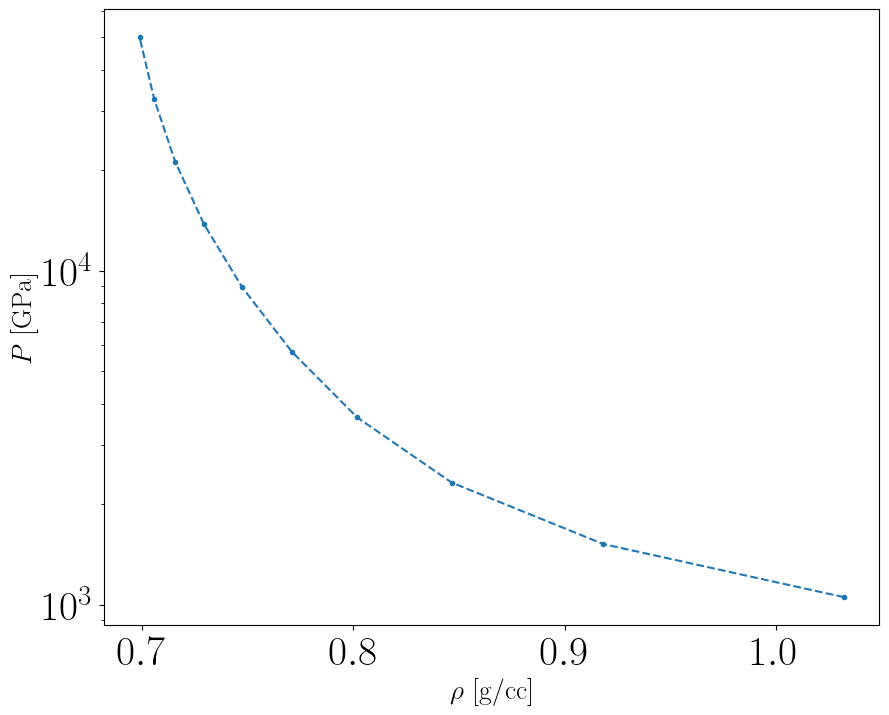

In [8]:
fig, ax = plt.subplots(figsize=(10,8))

H_ρ_gpercc_vals = np.array(H_info_list)[:,1]
H_P_GPa_vals = np.array(H_info_list)[:,2]*AU_to_Pa/1e9
ax.plot(H_ρ_gpercc_vals, H_P_GPa_vals,'--.')

ax.set_yscale('log')

# ax.set_ylim(np.min(P_GPa)*0.9, np.max(P_GPa)*1.1)
# ax.set_xlim(np.min(ρ_gpercc)*0.9, np.max(ρ_gpercc)*1.1)

ax.set_xlabel(r"$\rho$ [g/cc]", fontsize=20)
ax.set_ylabel(r"$P$ [GPa]", fontsize=20)

plt.subplots_adjust(hspace=0.5)
plt.show()

##### Diagnosing Low T Issues

In [7]:
plasma_test = lambda T_eV, ni_cc: PLASMA(Z, A, ni_cc, T_eV, T_eV, Zbar=Z, find_βuee=True,
                 βu_options = {'add_bridge':False,'bridge':'ocp', 'pseudopotential':False}, 
                 qsp_options= {'r_c':0,'which_Tij':'thermal'},
                 hnc_options= {'kappa_multiscale':10, 'R_max':10,'N_bins':500, 
                               'h_max':2e2,'oz_method':'standard'},
                 hnc_solve_options={'alpha_Picard':0.5, 'num_iterations':1e4})


In [8]:
plasma_type=plasma_type=plasma_test

ρ_gpercc = 0.44
T_eV = 2000/eV_to_K

ni_cc = ρ_gpercc/ (2*m_p*AU_to_g)
plasma = plasma_type(T_eV, ni_cc)
P_AU, E_AU  = plasma_output(plasma)
info = np.array([T_eV*eV_to_AU, ni_cc/cm_to_AU**3, P_AU, E_AU ])
H = Hugoniot_func(*info)
print(f"For ρ = {ρ_gpercc:.2f} [g/cc], H={H:.3f} [AU], P={P_AU*AU_to_Pa/1e9} [GPa], E={E_AU*AU_to_eV} [eV]" )

Te_in_eV: 0.172
Ti_in_eV: 0.172


/home/zach/plasma/hnc/hnc/PIE.py:186: RuntimeWarning: overflow encountered in exp
  integrand = lambda t: t*np.sin(sin_arg*t)/(1+np.exp(t**2-η))
/home/zach/plasma/hnc/hnc/PIE.py:193: RuntimeWarning: overflow encountered in exp
  f_of_k = 1/(  1+np.exp((dense_hnc.k_array/self.qsp.ri)**2/(2*m_e*self.qsp.Te) - η) )


0: Initial condition Total Error: 1.071e+01
Exiting status 0, reverting to best index so far: 508
Final iter:509, Total Error: 9.970e-09
For ρ = 0.44 [g/cc], H=0.075 [AU], P=-195.60135656457246 [GPa], E=-21.13621493642142 [eV]


In [9]:
plasma_type=plasma_test
ρ_gpercc = 0.47
T_eV = 2000/eV_to_K

ni_cc = ρ_gpercc/ (2*m_p*AU_to_g)
plasma = plasma_type(T_eV, ni_cc)
P_AU, E_AU  = plasma_output(plasma)
info = np.array([T_eV*eV_to_AU, ni_cc/cm_to_AU**3, P_AU, E_AU ])
H = Hugoniot_func(*info)
print(f"For ρ = {ρ_gpercc:.2f} [g/cc], H={H:.3f} [AU], P={P_AU*AU_to_Pa/1e9} [GPa], E={E_AU*AU_to_eV} [eV]" )

Te_in_eV: 0.172
Ti_in_eV: 0.172
0: Initial condition Total Error: 1.087e+01
Exiting status 0, reverting to best index so far: 520
Final iter:521, Total Error: 9.774e-09
For ρ = 0.47 [g/cc], H=0.102 [AU], P=-203.18168192395922 [GPa], E=-20.994903497646526 [eV]


In [10]:
plasma_type=plasma_type=plasma_test

ρ_gpercc = 1.1
T_eV = 2000/eV_to_K

ni_cc = ρ_gpercc/ (2*m_p*AU_to_g)
plasma = plasma_type(T_eV, ni_cc)
P_AU, E_AU  = plasma_output(plasma)
info = np.array([T_eV*eV_to_AU, ni_cc/cm_to_AU**3, P_AU, E_AU ])
H = Hugoniot_func(*info)
print(f"For ρ = {ρ_gpercc:.2f} [g/cc], H={H:.3f} [AU], P={P_AU*AU_to_Pa/1e9} [GPa], E={E_AU*AU_to_eV} [eV]" )

Te_in_eV: 0.172
Ti_in_eV: 0.172
0: Initial condition Total Error: 1.317e+01
Exiting status 0, reverting to best index so far: 682
Final iter:683, Total Error: 9.814e-09
For ρ = 1.10 [g/cc], H=0.434 [AU], P=-293.9458255406018 [GPa], E=-19.2168652469881 [eV]
